#  Predicting Airline Travel Category with Logistic Regression and Random Forest Model

## 1. Introduction

This process is to predict whether the category (business or for leisure) is by modeling after the reservation data in January and Febuary and to predict the travel category in March and April. Data is provided by an unnamed airline.

Note on data fields:
- TRAVEL_AGENCY: the agency that processed the booking
- CATEGORY: the purpose of the booking (L: Leisure, B: Business)
- CONFIRMATION_CODE: confirmation code for reservation
- DEPARTURE_DATE: departure date of reservation
- TICKET_ISSUE_DATE: date of booking for travel
- ORG: origin of travel
- DEST: destination of travel
- DISCOUNT_CODE: whether discount code is used for the reservation
- CABIN_CLASS: Economy (E) or first class (F)
- PRICE: price of the booking
- TRAVELER_COUNT: number of travelers on the reservation


## 2. Process
1. Load data from the given data set
2. Add Features based on business sense
3. Explore data set
4. Data Preparation
   * Remove missing data
   * Encode categorical feature to numerical feature
5. Modeling
   * Logistic Regression
   * Random Forest Model
   * Evaluation

In [1]:
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


In [2]:
# load excel file
data_file = 'Ticketing Dataset.xlsx'
df = pd.read_excel(data_file, header=0)

In [3]:
# Create copy of DataFrame and adding new features for exploration
explore_df = df.copy()

# Converting date fields to datetime format
explore_df['DEPARTURE_DATE'] = pd.to_datetime(explore_df['DEPARTURE_DATE'])
explore_df['TICKET_ISSUE_DATE'] = pd.to_datetime(explore_df['TICKET_ISSUE_DATE'])

# Adding day of week field (Monday = 0, Sunday = 6)
explore_df['DEPARTURE_DAY_OF_WEEK'] = pd.to_datetime(explore_df['DEPARTURE_DATE']).dt.dayofweek 

# Adding weekend flag for weekday vs. weekend comparison:
explore_df['WEEKEND'] = explore_df['DEPARTURE_DAY_OF_WEEK'].apply(lambda x: 1 if x == 5 or x == 6 else 0) 

# Adding binary discount code field (1 = discount code used)
explore_df['DISCOUNT_CODE'] = explore_df['DISCOUNT_CODE'].apply(lambda x: 0 if x == 'none' else 1)

# Adding booking behavior fields
explore_df['DATE_DIFF'] = (explore_df['DEPARTURE_DATE'] - explore_df['TICKET_ISSUE_DATE']).dt.days

# Create conditions and corresponding values
conditions = [
    (explore_df['DATE_DIFF'] == 0),
    (explore_df['DATE_DIFF'] > 0) & (explore_df['DATE_DIFF'] <= 7),
    (explore_df['DATE_DIFF'] > 7) & (explore_df['DATE_DIFF'] <= 30),
    (explore_df['DATE_DIFF'] > 30)

]
values = [0, 1, 2, 3] # 0 = day of flight, 1 = within a week, 2 = within a month, 3 = more than a month

# Create a new column using np.select(): fills in values based on specified conditions
explore_df['BOOKING_BEHAVIOR'] = np.select(conditions, values) 



In [4]:
# Checking field data types
explore_df.dtypes

TRAVEL_AGENCY                    object
CATEGORY                         object
CONFIRMATION_CODE                object
DEPARTURE_DATE           datetime64[ns]
TICKET_ISSUE_DATE        datetime64[ns]
ORG                              object
DEST                             object
DISCOUNT_CODE                     int64
CABIN_CLASS                      object
PRICE                           float64
TRAVELER_COUNT                    int64
DEPARTURE_DAY_OF_WEEK             int64
WEEKEND                           int64
DATE_DIFF                         int64
BOOKING_BEHAVIOR                  int64
dtype: object

## 3. Data Exploration

Exploration is carried out on data for feature selection:

In [5]:
explore_df.head()

,TRAVEL_AGENCY,CATEGORY,CONFIRMATION_CODE,DEPARTURE_DATE,TICKET_ISSUE_DATE,ORG,DEST,DISCOUNT_CODE,CABIN_CLASS,PRICE,TRAVELER_COUNT,DEPARTURE_DAY_OF_WEEK,WEEKEND,DATE_DIFF,BOOKING_BEHAVIOR
0,Company 000001,L,7S6J7Y,2018-03-20,2018-03-19,PHL,RDU,1,E,79.00,1,1,0,1,1
1,Company 000001,L,7SNR9T,2018-03-20,2018-03-20,PHL,RDU,1,E,79.00,1,1,0,0,0
2,Company 000001,L,9JW6H4,2018-03-21,2018-03-02,SFO,YYC,0,E,239.00,1,2,0,19,2
3,Company 000002,L,ZEKM8L,2018-04-03,2018-01-05,SFO,KTN,0,E,410.61,1,1,0,88,3
4,Company 000002,L,LC3DIT,2018-01-15,2018-01-10,YVR,SFO,0,E,150.79,1,0,0,5,1


In [6]:
# Looking further into numerical fields of data:
explore_df.describe()

,DISCOUNT_CODE,PRICE,TRAVELER_COUNT,DEPARTURE_DAY_OF_WEEK,WEEKEND,DATE_DIFF,BOOKING_BEHAVIOR
count,211530.000000,211530.000000,211530.000000,211530.000000,211530.000000,211530.000000,211530.000000
mean,0.217629,219.827875,1.290621,2.816782,0.229339,31.790711,2.135551
std,0.412635,242.249153,0.788100,1.981350,0.420408,34.460771,0.784744
min,0.000000,-123.020000,1.000000,0.000000,0.000000,-28.000000,0.000000
25%,0.000000,106.050000,1.000000,1.000000,0.000000,9.000000,2.000000
50%,0.000000,162.330000,1.000000,3.000000,0.000000,21.000000,2.000000
75%,0.000000,254.880000,1.000000,4.000000,0.000000,43.000000,3.000000
max,1.000000,25810.000000,38.000000,6.000000,1.000000,348.000000,3.000000


Checking for missing values in each field:

In [7]:
# Missing entries in data:
explore_df.isna().sum()

TRAVEL_AGENCY            0
CATEGORY                 0
CONFIRMATION_CODE        4
DEPARTURE_DATE           0
TICKET_ISSUE_DATE        0
ORG                      0
DEST                     0
DISCOUNT_CODE            0
CABIN_CLASS              0
PRICE                    0
TRAVELER_COUNT           0
DEPARTURE_DAY_OF_WEEK    0
WEEKEND                  0
DATE_DIFF                0
BOOKING_BEHAVIOR         0
dtype: int64

In [8]:
# Correlation among variables:
corr_df = explore_df.drop(columns=['CONFIRMATION_CODE', 'DEPARTURE_DATE', 'TICKET_ISSUE_DATE', 
                                   'DISCOUNT_CODE', 'DATE_DIFF'])

# Convert categorical variables to numerical codes
le = LabelEncoder()
for col in corr_df.columns:
    if corr_df[col].dtype == 'object':
        corr_df[col] = le.fit_transform(corr_df[col])


# Computing correlation between category and the other features:
corr_df.corr()['CATEGORY']


TRAVEL_AGENCY            0.178190
CATEGORY                 1.000000
ORG                     -0.011362
DEST                    -0.002325
CABIN_CLASS             -0.046267
PRICE                    0.011868
TRAVELER_COUNT           0.239492
DEPARTURE_DAY_OF_WEEK    0.103756
WEEKEND                  0.123902
BOOKING_BEHAVIOR         0.226095
Name: CATEGORY, dtype: float64

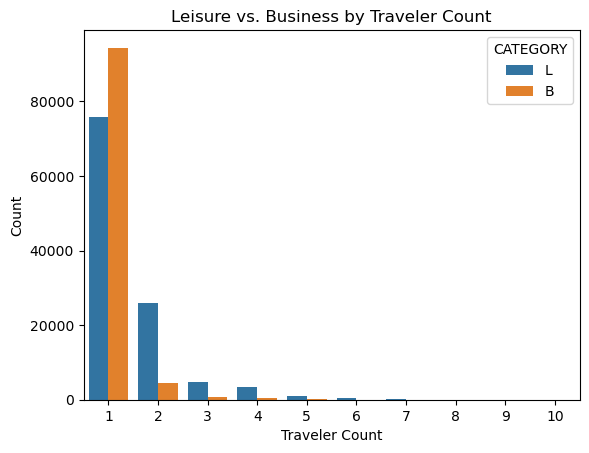

In [9]:
# Plot a bar plot of the counts of each category in the 'CATEGORY' column
sns.countplot(x='TRAVELER_COUNT', hue='CATEGORY', data=explore_df[explore_df['TRAVELER_COUNT'] <=10])
plt.title('Leisure vs. Business by Traveler Count')
plt.xlabel('Traveler Count')
plt.ylabel('Count')
plt.show()

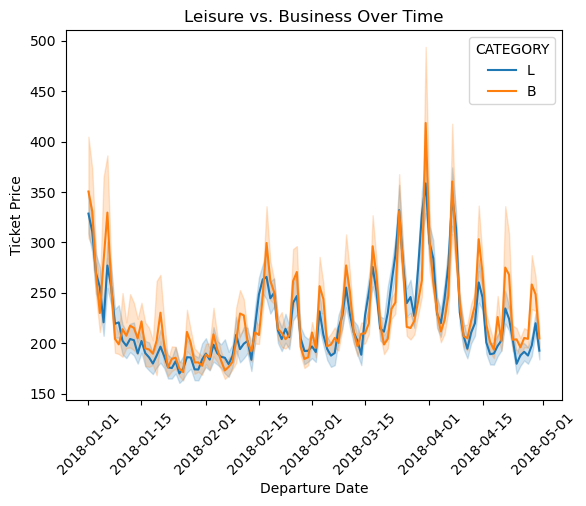

In [10]:
# Plot line chart with multiple categories
sns.lineplot(data=explore_df, x='DEPARTURE_DATE', y='PRICE', hue='CATEGORY')
plt.title("Leisure vs. Business Over Time")
plt.xlabel("Departure Date")
plt.ylabel("Ticket Price")
plt.xticks(rotation=45)
plt.show()

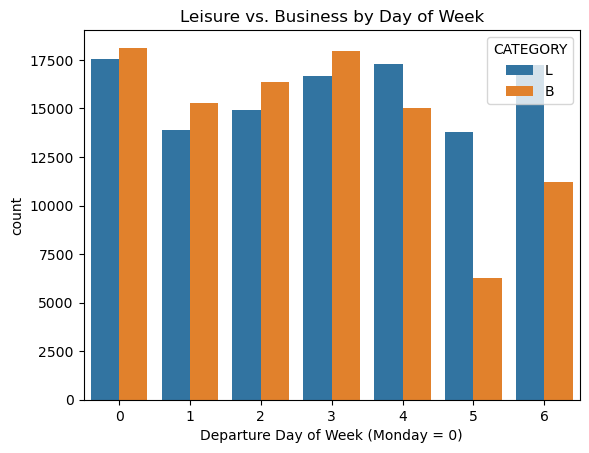

In [11]:
# Plot line chart with multiple categories
plt.title("Leisure vs. Business by Day of Week")
sns.countplot(x='DEPARTURE_DAY_OF_WEEK', hue='CATEGORY', data=explore_df)
plt.xlabel('Departure Day of Week (Monday = 0)') 
plt.show()

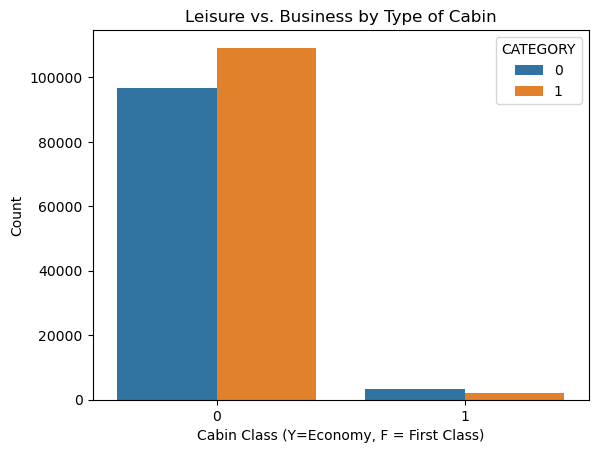

In [22]:
# Plot line chart with categories
plt.title("Leisure vs. Business by Type of Cabin")
sns.countplot(x='CABIN_CLASS', hue='CATEGORY', data=explore_df)
plt.xlabel('Cabin Class (Y=Economy, F = First Class)')
plt.ylabel('Count')
plt.show()

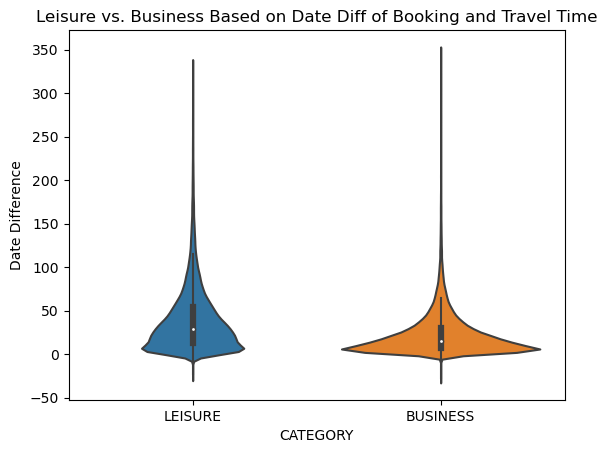

In [ ]:
# Plot catplot with multiple categories
box_plot = sns.violinplot(data=explore_df, x="CATEGORY", y="DATE_DIFF")
# medians = explore_df.groupby(['CATEGORY'])['DATE_DIFF'].median()
# vertical_offset = explore_df['DATE_DIFF'].median() * 0.0 # offset from median for display

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset, medians[xtick], 
#             horizontalalignment='right',size='x-small',color='k',weight='semibold')

plt.title("Leisure vs. Business Based on Date Diff of Booking and Travel Time") #median = 15 and 29 respectively
plt.ylabel('Date Difference')
plt.show()

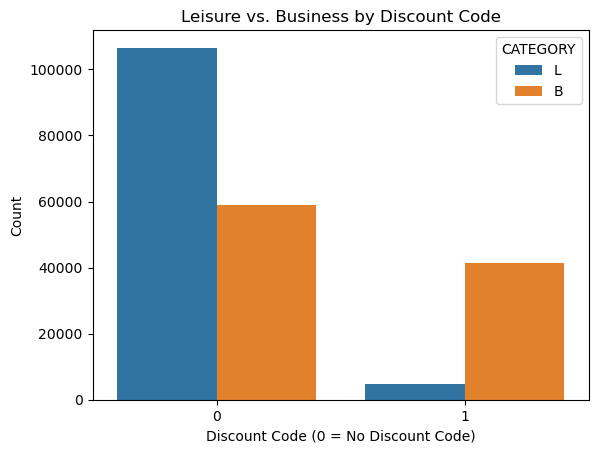

In [ ]:
# Plot chart with multiple categories
plt.title("Leisure vs. Business by Discount Code")
sns.countplot(x='DISCOUNT_CODE', hue='CATEGORY', data=explore_df)
plt.xlabel('Discount Code (0 = No Discount Code)')
plt.ylabel('Count')
plt.show()

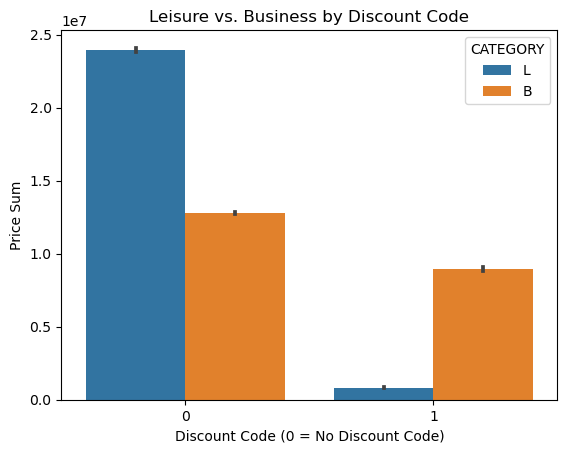

In [13]:
# Plot chart with multiple categories
plt.title("Leisure vs. Business by Discount Code")
sns.barplot(data=explore_df, x='DISCOUNT_CODE', y='PRICE', hue='CATEGORY', estimator = np.sum)
plt.xlabel('Discount Code (0 = No Discount Code)')
plt.ylabel('Price Sum')
plt.show()

## 4. Data Preparation

The following process uses average value of the columns with missing data to fill out the empty values:

In [14]:
# Dropping rows with empty values in data sets since only a small amount of data is missing:
explore_df = explore_df.dropna()

# Dropping rows with departure dates after ticket issuing date:
explore_df = explore_df[explore_df['DATE_DIFF']>=0]


In [15]:
# Converting categorical variables to numbers:
le = LabelEncoder()
for col in explore_df.columns:
    if explore_df[col].dtype == 'object':
        explore_df[col] = le.fit_transform(explore_df[col])


In [17]:
# Creating training and test data frames based on months:
train_df = explore_df[(explore_df['DEPARTURE_DATE'].dt.month == 1) | (explore_df['DEPARTURE_DATE'].dt.month == 2)]
test_df = explore_df[(explore_df['DEPARTURE_DATE'].dt.month == 3) | (explore_df['DEPARTURE_DATE'].dt.month == 4)]

# Dropping unnecessary fields:
train_df = train_df.drop(columns=['CONFIRMATION_CODE', 'DEPARTURE_DATE', 'TICKET_ISSUE_DATE', 
                                   'DISCOUNT_CODE', 'DATE_DIFF', 'DEPARTURE_DAY_OF_WEEK'])
test_df = test_df.drop(columns=['CONFIRMATION_CODE', 'DEPARTURE_DATE', 'TICKET_ISSUE_DATE', 
                                   'DISCOUNT_CODE', 'DATE_DIFF', 'DEPARTURE_DAY_OF_WEEK'])

## 5. Modeling


Creating arrays to prepare data sets for modeling:

In [18]:
# Split the data into training and testing sets

X_train = train_df.drop('CATEGORY', axis=1)
y_train = train_df['CATEGORY']
X_test = test_df.drop('CATEGORY', axis=1)
y_test = test_df['CATEGORY']


In [19]:
print('Training data set size:',len(X_train))
print('Testing data set size:', len(X_test))

Training data set size: 97644
Testing data set size: 113778


In [20]:
# Instantiate the logistic regression model
logreg = LogisticRegression()

# Train the model on the training set
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the performance of the model
accuracy = logreg.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision) # Precision measures the proportion of true positive instances among all instances predicted as positive by the model.
print("Recall:", recall) # Recall measures the proportion of true positive instances among all actual positive instances in the dataset
print("F1:", recall) #A high F1-score indicates that a model is performing well in both precision and recall.


Accuracy: 0.673812160523124
Precision: 0.7121332837591402
Recall: 0.6585565524919772
F1: 0.6585565524919772


/Users/bkuo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Instantiate the random forest model
rf = RandomForestClassifier()

# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the performance of the model
accuracy = rf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", recall)


Accuracy: 0.9572061382692612
Precision: 0.9648202973817833
Recall: 0.9551051149387648
F1: 0.9551051149387648


## 7. Conclusion

With the selected features, random forest outperforms the logistic regression model by producing an accuracy of 97% when predicting the March and April categories. (75% for logistic regression)